In [6]:
!pip install --upgrade -q kaggle 
!mkdir /root/.kaggle
import json 
token = {
    
    "username": "ifrahandleeb",
    "key": "7d32d51ce48e80317141c1a4fc7c3c23"
    
}

with open('/root/.kaggle/kaggle.json' , 'w') as config_file:

  json.dump(token , config_file)

!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d alexattia/the-simpsons-characters-dataset

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 99% 1.07G/1.08G [00:11<00:00, 90.1MB/s]
100% 1.08G/1.08G [00:11<00:00, 102MB/s] 


In [7]:
import zipfile 
zip_ref = zipfile.ZipFile("/content/the-simpsons-characters-dataset.zip")
zip_ref.extractall()
zip_ref.close()

In [8]:
!ls /content/simpsons_dataset

abraham_grampa_simpson	  homer_simpson        otto_mann
agnes_skinner		  kent_brockman        patty_bouvier
apu_nahasapeemapetilon	  krusty_the_clown     principal_skinner
barney_gumble		  lenny_leonard        professor_john_frink
bart_simpson		  lionel_hutz	       rainier_wolfcastle
carl_carlson		  lisa_simpson	       ralph_wiggum
charles_montgomery_burns  maggie_simpson       selma_bouvier
chief_wiggum		  marge_simpson        sideshow_bob
cletus_spuckler		  martin_prince        sideshow_mel
comic_book_guy		  mayor_quimby	       simpsons_dataset
disco_stu		  milhouse_van_houten  snake_jailbird
edna_krabappel		  miss_hoover	       troy_mcclure
fat_tony		  moe_szyslak	       waylon_smithers
gil			  ned_flanders
groundskeeper_willie	  nelson_muntz


In [11]:
#!ls /content/kaggle_simpson_testset/kaggle_simpson_testset

In [36]:
!pip install split-folders 
import splitfolders

splitfolders.ratio("/content/simpsons_dataset" , output = 'data' , seed=1337 , ratio=(0.3, 0.7))

Copying files: 20933 files [00:10, 2042.96 files/s]


In [37]:
!ls /content/data

train  val


In [38]:
!ls /content/data/train 

abraham_grampa_simpson	  homer_simpson        otto_mann
agnes_skinner		  kent_brockman        patty_bouvier
apu_nahasapeemapetilon	  krusty_the_clown     principal_skinner
barney_gumble		  lenny_leonard        professor_john_frink
bart_simpson		  lionel_hutz	       rainier_wolfcastle
carl_carlson		  lisa_simpson	       ralph_wiggum
charles_montgomery_burns  maggie_simpson       selma_bouvier
chief_wiggum		  marge_simpson        sideshow_bob
cletus_spuckler		  martin_prince        sideshow_mel
comic_book_guy		  mayor_quimby	       simpsons_dataset
disco_stu		  milhouse_van_houten  snake_jailbird
edna_krabappel		  miss_hoover	       troy_mcclure
fat_tony		  moe_szyslak	       waylon_smithers
gil			  ned_flanders
groundskeeper_willie	  nelson_muntz


In [39]:
!ls /content/data/val

abraham_grampa_simpson	  homer_simpson        otto_mann
agnes_skinner		  kent_brockman        patty_bouvier
apu_nahasapeemapetilon	  krusty_the_clown     principal_skinner
barney_gumble		  lenny_leonard        professor_john_frink
bart_simpson		  lionel_hutz	       rainier_wolfcastle
carl_carlson		  lisa_simpson	       ralph_wiggum
charles_montgomery_burns  maggie_simpson       selma_bouvier
chief_wiggum		  marge_simpson        sideshow_bob
cletus_spuckler		  martin_prince        sideshow_mel
comic_book_guy		  mayor_quimby	       simpsons_dataset
disco_stu		  milhouse_van_houten  snake_jailbird
edna_krabappel		  miss_hoover	       troy_mcclure
fat_tony		  moe_szyslak	       waylon_smithers
gil			  ned_flanders
groundskeeper_willie	  nelson_muntz


In [40]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMG_SHAPE = (224 , 224)

train_dir = "/content/data/train/"
test_dir = "/content/data/val"

train_datagen = ImageDataGenerator(rescale = 1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

print("Training Images")

train_data = train_datagen.flow_from_directory(train_dir , 
                                               target_size = IMG_SHAPE , 
                                               batch_size = 32 , 
                                               class_mode = "categorical")

print("Testing Images")

test_data = test_datagen.flow_from_directory(test_dir , 
                                             target_size = IMG_SHAPE , 
                                             batch_size = 32 , 
                                             class_mode = "categorical")

Training Images
Found 16727 images belonging to 43 classes.
Testing Images
Found 14673 images belonging to 43 classes.


In [41]:
import datetime 
def create_tensorboard_callback(dir_name , experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S)")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"saving to : {log_dir}")
  return tensorboard_callback

In [42]:
eff_url = "https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1"

res_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

In [43]:
import tensorflow as tf
import tensorflow_hub as hub 
from tensorflow.keras import layers

In [44]:
def create_model(model_url , num_classes=43):

  feature_extractor_layer = hub.KerasLayer(model_url , 
                                           trainable = False ,
                                           name="feature_extractor_layer" , 
                                           input_shape = IMG_SHAPE+(3 , ))
  
  model = tf.keras.Sequential([
                               feature_extractor_layer , 
                               layers.Dense(num_classes , activation="softmax" , name = "output_layer")
  ])

  return model

In [45]:
resnet_model = create_model(res_url , 
                            num_classes=train_data.num_classes)

In [46]:
train_data.num_classes

43

In [47]:
resnet_model.compile(loss = "categorical_crossentropy" , 
                     optimizer = tf.keras.optimizers.Adam() , 
                     metrics=["accuracy"])

In [48]:
resnet_history = resnet_model.fit(train_data , 
                                  epochs = 5 , 
                                  steps_per_epoch = len(train_data) , 
                                  validation_data = test_data , 
                                  validation_steps = len(test_data), 
                                  callbacks = [create_tensorboard_callback(dir_name="tensorflow_hub" , 
                                                                           experiment_name = "resnet50v2") 
                                  ])

saving to : tensorflow_hub/resnet50v2/20210719-035043)
Epoch 1/5
523/523 [==============================] - 3849s 7s/step - loss: 1.8921 - accuracy: 0.5128 - val_loss: 1.2492 - val_accuracy: 0.6800
Epoch 2/5
523/523 [==============================] - 3745s 7s/step - loss: 1.0943 - accuracy: 0.7107 - val_loss: 0.9492 - val_accuracy: 0.7568
Epoch 3/5
523/523 [==============================] - 3700s 7s/step - loss: 0.8530 - accuracy: 0.7748 - val_loss: 0.7904 - val_accuracy: 0.7981
Epoch 4/5
523/523 [==============================] - 3683s 7s/step - loss: 0.7057 - accuracy: 0.8154 - val_loss: 0.7334 - val_accuracy: 0.8099
Epoch 5/5
523/523 [==============================] - 3727s 7s/step - loss: 0.6032 - accuracy: 0.8449 - val_loss: 0.6499 - val_accuracy: 0.8335


In [51]:
import matplotlib.pyplot as plt 

def plot_loss_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  plt.plot(epochs , loss  , label="training_loss")
  plt.plot(epochs , val_loss , label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs , accuracy  , label="training_accuracy")
  plt.plot(epochs , val_accuracy , label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend();

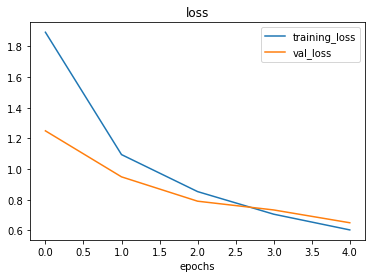

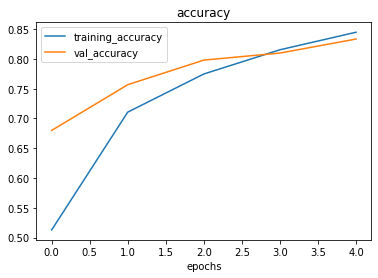

In [52]:
plot_loss_curves(resnet_history)

In [56]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extractor_layer (Ker (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 43)                88107     
Total params: 23,652,907
Trainable params: 88,107
Non-trainable params: 23,564,800
_________________________________________________________________
